In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import scipy.interpolate as interpolate
from glob import glob
from tools import unique_maxs, local_max, generate_Rv_Plots
from datetime import datetime as dt
import pytz # for seting datetime timezone

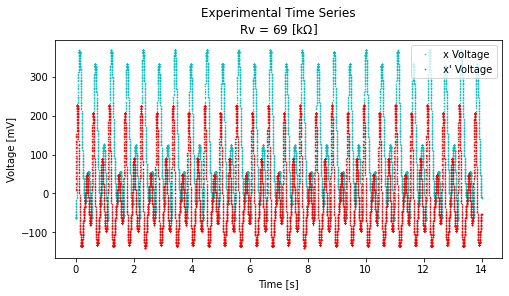

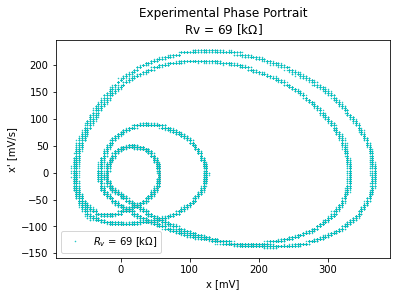

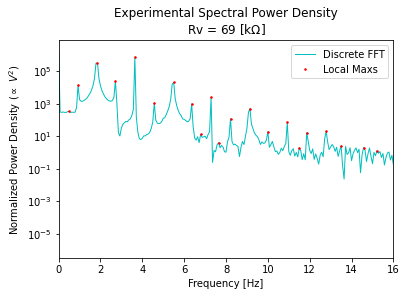

Number of Periods = 4
Unique x maxes: [0.056 0.128 0.332 0.368] [V]
x waveform amplitude:  0.44 [V]
x' waveform amplitude: 0.368 [V]
Spectral Power Desnitie Peaks: [ 0.5    0.929  1.857  2.714  3.643  4.571  5.5    6.357  6.786  7.286
  7.643  8.214  9.143 10.    10.929 11.5   11.857 12.786 13.5   14.571
 15.214] [Hz]


In [ ]:
newFigFilePath = "/work/Notes/Experimental/2022-01-22_PreliminaryPlotsPerRv/"
fileToAnalysepath = "/work/Data_experimental/Coarse_sweep1/Rv_69.txt"
plotDict = generate_Rv_Plots(fileToAnalysepath,diffPeakThresh = 15)#, phase = False, spectrum= False, x_primeTime= False)#,x_Time = False, x_primeTime=False, phase = False, spectrum = False)
#generate_Rv_Plots("/work/Data_experimental/Coarse_sweep2/Rv_70.txt",diffPeakThresh = 15 , phase = False, spectrum= False, x_primeTime= False)
# sorry if this functions a bit messy I just wanted a quick way to get standardized plots to compare, ill comment when I can



/work/Data_experimental/Coarse_sweep2/Rv_70.25.txt
[70.25, 75.0, 72.0, 70.5, 69.5, 69.75, 70.125, 70.75, 70.0, 45.0, 70.0, 71.0, 70.55, 69.875, 85.0, 70.625, 70.05, 71.0, 95.0, 67.25, 54.35, 55.0, 100.0, 60.0, 54.6, 67.0, 54.1, 69.0, 54.25, 67.5, 70.0, 110.0, 67.125, 68.0, 66.0, 54.7, 66.5, 54.0, 54.4, 65.0, 54.3, 50.0, 90.0, 80.0, 54.2, 54.5, 120.0, 40.0, 55.5]
[[0.044, 0.112, 0.132, 0.312, 0.324, 0.352], [0.01, 0.03, 0.046, 0.062, 0.098, 0.11, 0.126, 0.17, 0.182, 0.206, 0.23, 0.242, 0.29, 0.306, 0.33, 0.342, 0.358, 0.37, 0.382], [0.032, 0.048, 0.06, 0.072, 0.092, 0.12, 0.16, 0.176, 0.296, 0.324, 0.336, 0.348, 0.36], [0.044, 0.108, 0.136, 0.308, 0.324, 0.352], [0.052, 0.112, 0.316, 0.348], [0.048, 0.116, 0.316, 0.352], [0.044, 0.116, 0.128, 0.312, 0.352], [0.04, 0.052, 0.092, 0.104, 0.12, 0.132, 0.144, 0.308, 0.32, 0.332, 0.348, 0.36], [0.048, 0.12, 0.316, 0.352], [0.162], [0.044, 0.108, 0.136, 0.312, 0.324, 0.356], [0.04, 0.052, 0.084, 0.09599999, 0.112, 0.124, 0.14, 0.152, 0.304, 0.

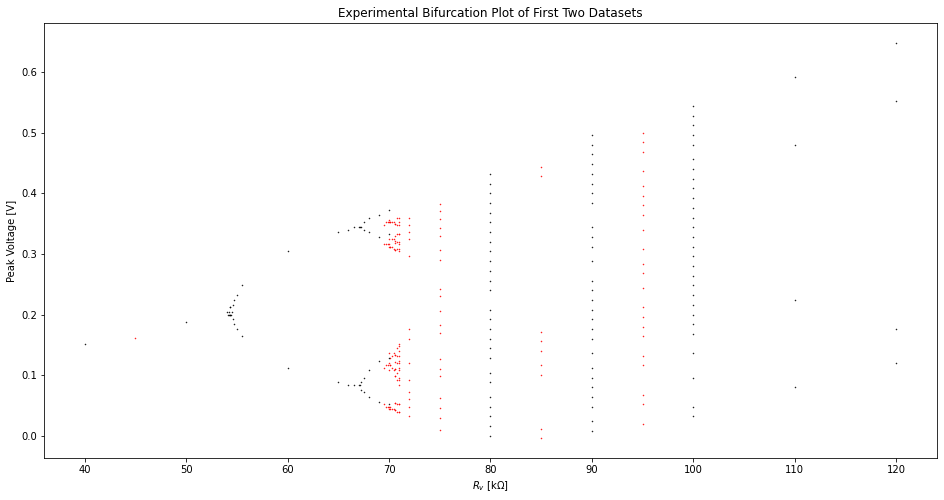

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
[4.327868852459021, 0.6853932584269652]


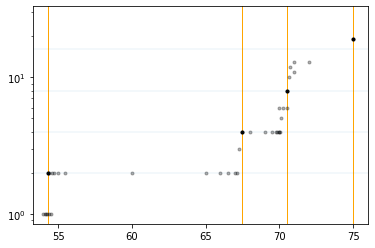

In [ ]:
filenames = glob("/work/Data_experimental/Coarse_sweep*/*")
bifurcation = []
Rv_arr = []
day_arr = []
data = {}

#fig = plt.figure(figsize = (16,8))
for filename in filenames:
    
    #dayVal = filename[36]
    #print(dayVal)
    if filename.split('/')[-2][-1] == '2':
        day_arr.append(2)
    else:
        day_arr.append(1) # nice

    t, negative_x_prime, x = np.genfromtxt(filename, skip_header = 12, delimiter = ',', unpack = True)
    t = t - np.min(t)
    x_prime = -negative_x_prime

    Rv = float(filename.split('/')[-1][3:-4])
    Rv_arr.append(Rv)
    data[filename.split('/')[-1][:-4]] = (t,x)
    maxs = unique_maxs(x, N = 50, error_tol = 1e-2)
    bifurcation.append(maxs)

k = 1.052

print(Rv_arr)
Rv_arr_forLater = Rv_arr
print(bifurcation)
for Rv, bif, day in zip(Rv_arr, bifurcation,day_arr):
    if day == 2:
        #bif = k*np.array(bif) 
        colourVal = "Red"
    else:
        colourVal = "Black"
    plt.plot(Rv*np.ones(len(bif)), bif, '.',color = colourVal, markersize = 1)


tz = pytz.timezone('US/Pacific')
dateString = str(dt.now(tz).date())
plt.xlabel(r"$R_v$ [k$\Omega$]")
plt.ylabel(r"Peak Voltage [V]")
plt.title("Experimental Bifurcation Plot of First Two Datasets")

plt.savefig("/work/Notes/Experimental/"+dateString+"-ExperimentalBifurcation_v2.png",dpi = 600)
plt.show()

In [ ]:
# Try to find bifurcations by countim # periods
uniqueMaxArray = bifurcation
RvArray = np.array(Rv_arr_forLater)
#combinedBifurcationArray = np.column_stack((RvArray,uniqueMaxArray))
sortedIndexes = np.argsort(RvArray,axis = 0)

def find_experimental_splitting(unique_max_array,sortedIndexes):
    '''takes the result of finding unique maxs at each Rv and finds bifurcation spliting indeces'''
    indexes = []
    numPeriods = []
    split_value = 2
    for index in sortedIndexes:
        sub_array = unique_max_array[index]
        split = True

        if len(sub_array) >= split_value:
            indexes.append(index)
            split_value *= 2
            numPeriods.append(len(sub_array))
        else:
            split = False

    #print(indexes)
    return np.array(indexes),np.array(numPeriods)

idx,periods = find_experimental_splitting(uniqueMaxArray,sortedIndexes)
Rv_bif = RvArray[idx]
#print(idx)
#print(periods)
#print(Rv_bif)
for Rv in Rv_bif:
    plt.axvline(Rv,linewidth = 1, color = "Orange")
plt.plot(np.array(RvArray),np.array(peakNumber_Array),'k.',alpha = 0.3)
plt.plot(Rv_bif,periods,"k.")
plt.axhline(2,linewidth = 0.1)
plt.axhline(4,linewidth = 0.1)
plt.axhline(8,linewidth = 0.1)
plt.axhline(16,linewidth = 0.1)

faigenbaum_experimental = []
delta_Rvs = np.diff(Rv_bif)
for _ in range(len(delta_Rvs)-1):
    num = delta_Rvs[_]
    denom = delta_Rvs[_+1]
    faigenbaum_experimental.append(num/denom)
plt.xlim(np.min(Rv_bif)-1,np.max(Rv_bif)+1)
plt.yscale("Log")

print(faigenbaum_experimental)

['/work/Data_experimental/Coarse_sweep1/Rv_54.6.txt', '/work/Data_experimental/Coarse_sweep1/Rv_54.5.txt', '/work/Data_experimental/Coarse_sweep1/Rv_54.7.txt', '/work/Data_experimental/Coarse_sweep1/Rv_55.txt', '/work/Data_experimental/Coarse_sweep1/Rv_55.5.txt', '/work/Data_experimental/Coarse_sweep1/Rv_60.txt']
[4.19745047e-02 5.44992575e+01]
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


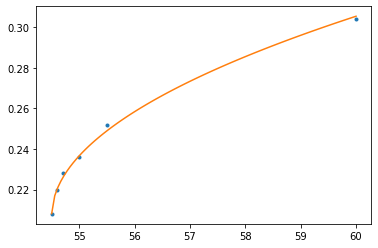

In [ ]:
filenames2 = [ "/work/Data_experimental/Coarse_sweep1/Rv_54.6.txt", "/work/Data_experimental/Coarse_sweep1/Rv_54.5.txt", 
                "/work/Data_experimental/Coarse_sweep1/Rv_54.7.txt","/work/Data_experimental/Coarse_sweep1/Rv_55.txt"
                ,"/work/Data_experimental/Coarse_sweep1/Rv_55.5.txt","/work/Data_experimental/Coarse_sweep1/Rv_60.txt"]
print(filenames2)hm ok my
data = []

Rv_arr = []
for filename in filenames2:
    t, negative_x_prime, x = np.genfromtxt(filename, skip_header = 12, delimiter = ',', unpack = True)
    t = t - np.min(t)
    x_prime = -negative_x_prime

    Rv = float(filename.split('/')[-1][3:-4])
    Rv_arr.append(Rv)
    
    
    maxs = max(unique_maxs(x, N = 500))
    data.append(maxs)
    

Rv_arr = np.array(Rv_arr) # like here?

def sqrt_func(Rv, a, b):
    return a*(Rv - b)**(1/2) + 0.207



plt.plot(Rv_arr, data, '.')

pOpt, pCov = curve_fit(sqrt_func, Rv_arr, data, p0 = [0.005, 54])
print(pOpt)

dx = np.linspace(min(Rv_arr), max(Rv_arr), 100)
plt.plot(dx, sqrt_func(dx, *pOpt))

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
[4.046153846153846, 6.5, 0.05555555555555555]


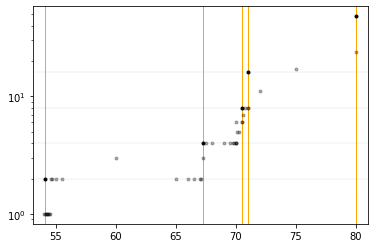

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4939151a-2261-4374-8b6d-a725368f8dc5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>